In [20]:
import pickle
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

seed =0

EXERCISE 1

In [11]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def one_hot_encode(y,K):

	y_hat = np.zeros(shape=(K, len(y)))

	for il, yi in enumerate(y):
		y_hat[int(yi),il] = 1

	return y_hat


def LoadBatch(filepath):
  data = unpickle(filepath)
  #print(data.keys())
  X     = np.array(data[b'data']).T
  y     = np.array(data[b'labels'])

  K     = len(np.unique(y))
  Y     = one_hot_encode(y,K)

  return X, Y , y
def preprocess(X_trn, X_tst, X_val):

  mu    = np.mean(X_trn, axis=1).reshape(-1, 1)
  sigma = np.std(X_trn, axis=1).reshape(-1, 1 )

  X_trn = (X_trn - mu)/sigma
  X_tst = (X_tst - mu)/sigma
  X_val = (X_val - mu)/sigma

  return X_trn, X_tst, X_val
def dl_Full_batch(val):
    """
    A dataloader for all five batches

    Args:
      val: number of data used for valiation
    """

    X_train1, Y_train1, y_train1 = LoadBatch("/home/mech/sanchis/sanchis/PHD_COURSES/Deep_learning/Assign_1/DirName/data/cifar-10-batches-py/data_batch_1")
    X_train2, Y_train2, y_train2 = LoadBatch("/home/mech/sanchis/sanchis/PHD_COURSES/Deep_learning/Assign_1/DirName/data/cifar-10-batches-py/data_batch_2")
    X_train3, Y_train3, y_train3 = LoadBatch("/home/mech/sanchis/sanchis/PHD_COURSES/Deep_learning/Assign_1/DirName/data/cifar-10-batches-py/data_batch_3")
    X_train4, Y_train4, y_train4 = LoadBatch("/home/mech/sanchis/sanchis/PHD_COURSES/Deep_learning/Assign_1/DirName/data/cifar-10-batches-py/data_batch_4")
    X_train5, Y_train5, y_train5 = LoadBatch("/home/mech/sanchis/sanchis/PHD_COURSES/Deep_learning/Assign_1/DirName/data/cifar-10-batches-py/data_batch_5")

    X_train = np.concatenate((X_train1, X_train2, X_train3, X_train4, X_train5),axis=1)
    Y_train = np.concatenate((Y_train1, Y_train2, Y_train3, Y_train4, Y_train5),axis=1)
    y_train = np.concatenate((y_train1, y_train2, y_train3, y_train4, y_train5))

    X_val = X_train[:, -val:]
    Y_val = Y_train[:,-val:]
    y_val = y_train[-val:]
    X_trn = X_train[:, :-val]
    Y_trn = Y_train[:,:-val]
    y_trn = y_train[:-val]

    X_tst, Y_tst, y_tst = LoadBatch("/home/mech/sanchis/sanchis/PHD_COURSES/Deep_learning/Assign_1/DirName/data/cifar-10-batches-py/test_batch")
    X_trn, X_tst, X_val = preprocess(X_trn, X_tst, X_val)

    return X_trn, Y_trn, y_trn, X_tst, Y_tst, y_tst, X_val, Y_val, y_val

In [9]:
def initialize_weights(input_dim, hidden_dim, output_dim, seed=seed, std=0.01):

    scale1 = 1/np.sqrt(input_dim)
    scale2 = 1/np.sqrt(hidden_dim)

    np.random.seed(seed)
    W1 = np.random.normal(size=( hidden_dim,input_dim), loc=0, scale=scale1)
    W2 = np.random.normal(size=( output_dim, hidden_dim), loc=0, scale=scale2)

    b1 = np.zeros(shape=(hidden_dim, 1))
    b2 = np.zeros(shape=(output_dim,1))

    return W1, b1, W2, b2

def _he_init(d,stdev=1e-2):
    """He Kaiming initialization"""

    W      = np.random.normal(0, stdev, size=(d[0], d[1]))
    b      = np.zeros(d[0]).reshape(d[0], 1)
    gamma  = np.ones((d[0], 1))
    beta   = np.zeros((d[0], 1))
    mu_av  = np.zeros((d[0], 1))
    var_av = np.zeros((d[0], 1))

    return W, b, gamma, beta, mu_av, var_av

def initialize_weights_k(input_dim, hidden_dim, output_dim, num_hidden_layers, seed=seed, std=0.01):
    np.random.seed(seed)
    parameters = {}

    # Initialize weights and biases for the first hidden layer
    scale1 = 1 / np.sqrt(input_dim)
    parameters['W1'] = np.random.normal(size=(hidden_dim, input_dim), loc=0, scale=scale1)
    parameters['b1'] = np.zeros((hidden_dim, 1))

    # Initialize weights and biases for the hidden layers
    for l in range(2, num_hidden_layers):
        scale = 1 / np.sqrt(hidden_dim)
        parameters['W' + str(l)] = np.random.normal(size=(hidden_dim, hidden_dim), loc=0, scale=scale)
        parameters['b' + str(l)] = np.zeros((hidden_dim, 1))

    # Initialize weights and biases for the output layer
    scale_out = 1 / np.sqrt(hidden_dim)
    parameters['W' + str(num_hidden_layers)] = np.random.normal(size=(output_dim, hidden_dim), loc=0, scale=scale_out)
    parameters['b' + str(num_hidden_layers)] = np.zeros((output_dim, 1))

    return parameters

In [12]:
# Load CIFAR-10 dataset

data_batch1 = "/home/mech/sanchis/sanchis/PHD_COURSES/Deep_learning/Assign_1/DirName/data/cifar-10-batches-py/data_batch_1"
data_batch2 = "/home/mech/sanchis/sanchis/PHD_COURSES/Deep_learning/Assign_1/DirName/data/cifar-10-batches-py/data_batch_2"
test_batch  = "/home/mech/sanchis/sanchis/PHD_COURSES/Deep_learning/Assign_1/DirName/data/cifar-10-batches-py/test_batch"

X_trn, Y_trn, y_trn = LoadBatch(data_batch1)
X_val, Y_val, y_val = LoadBatch(data_batch2)
X_tst, Y_tst, y_tst = LoadBatch(test_batch)

X_trn, X_tst, X_val = preprocess(X_trn, X_tst, X_val)

print(f"X_trn:{X_trn.shape}, Y_trn:{Y_trn.shape}, y_trn:{y_trn.shape},type:{type(X_trn[0,0])}")

X_trn:(3072, 10000), Y_trn:(10, 10000), y_trn:(10000,),type:<class 'numpy.float64'>


In [7]:
input_dim = X_trn.shape[0]
hidden_dim = 50
output_dim = Y_trn.shape[0]
weights = initialize_weights_k(input_dim, hidden_dim, output_dim,4)
print(weights['W3'].shape,weights['W4'].shape)

#print(f"shapes of W1:{W1.shape}, W2:{W2.shape}, b1:{b1.shape}, b2:{b2.shape},{W3.shape}, W4:{W4.shape}, b3:{b3.shape}, b4:{b4.shape} ")

(50, 50) (10, 50)


In [13]:
def customReLu(S):
    H = S
    H[H<0] = 0
    return H

def softmax(S):
    exponential_S = np.exp(S)
    P = exponential_S/exponential_S.sum(axis=0) ###
    return P

def EvaluateClassifier(X, W1, b1, W2, b2):

    S =  W1 @ X + b1
    H = customReLu(S)
    #print(f"H: {H.shape}, W2:{W2.shape}")
    S =  W2 @ H + b2
    P = softmax(S)
    return P, H

def EvaluateClassifier_k(X, weights):
    num_layers = len(weights) // 2  # // operator ensures integer division

    activations = {}
    activations['A0'] = X  # Input activation

    for l in range(1, num_layers + 1):
        W = weights['W' + str(l)]
        b = weights['b' + str(l)]
        A_prev = activations['A' + str(l - 1)]
        
        S = W @ A_prev + b
        if l < num_layers:
            H = customReLu(S)
            activations['H' + str(l)] = H  # Hidden layer activation
            activations['A' + str(l)] = H  # Update activation for next layer
        else:
            P = softmax(S)
    
    return P, activations

In [9]:
P, activations = EvaluateClassifier_k(X_trn[:, 0:100], weights)
print(P.shape,activations['A1'].shape,activations['A2'].shape,activations['A3'].shape)

(10, 100) (50, 100) (50, 100) (50, 100)


GRADIENTS CHECKINGS 


In [14]:
def ComputeCost(X, b,Y, weights, lamda,activations,gamma, beta,use_batch_norm=True):
    if use_batch_norm:
        p, _ = EvaluateClassifier_test(X, b,weights,activations,gamma, beta,use_batch_norm=True)
    else:
        p, _ = EvaluateClassifier_test(X, b,weights,activations,gamma, beta,use_batch_norm=False)

    # Clip probabilities to avoid numerical instability
    p = np.clip(p, 1e-15, 1 - 1e-15)

    # Cross-entropy loss
    loss_cross = -np.mean(np.sum(Y * np.log(p), axis=0))

    # Regularization term
    reg = 0
    num_layers = len(weights) // 2
    for l in range(1, num_layers + 1):
        W = weights['W' + str(l)]
        reg += lamda * np.sum(W**2)

    # Total cost
    Total = loss_cross + reg

    return Total, loss_cross

def ComputeAccuracy(X, b,Y, weights,activations,gamma, beta,use_batch_norm=True):

    if use_batch_norm:
        P, H = EvaluateClassifier_test(X, b,weights,activations,gamma, beta,use_batch_norm=True)
    else:
        P, H = EvaluateClassifier_test(X, b,weights,activations,gamma, beta,use_batch_norm=False)

    #print(f"P:{P.shape}, Y:{Y.shape}")
    #print(f"P:{np.argmax(P,axis=0)}, Y:{np.argmax(Y, axis =0 )}")

    true_pos = np.sum(np.argmax(P,axis=0)== np.argmax(Y, axis = 0))  ###

    acc = true_pos/Y.shape[1]

    return acc

def ComputeAccuracy_test(X, b,Y, weights,activations,gamma,beta,use_batch_norm=True):

    if use_batch_norm:
        P, H = EvaluateClassifier_test(X, b,weights,activations,gamma,beta,use_batch_norm=True)
    else:
        P, H = EvaluateClassifier_test(X, b,weights,activations,gamma,beta,use_batch_norm=False)

    #print(f"P:{P.shape}, Y:{Y.shape}")
    #print(f"P:{np.argmax(P,axis=0)}, Y:{np.argmax(Y, axis =0 )}")

    true_pos = np.sum(np.argmax(P,axis=0)== np.argmax(Y, axis = 0))  ###

    acc = true_pos/Y.shape[1]

    return acc
def ComputeGradients(X, Y, P, activations, weights, lamda, hidden_layer_dims):
    n = X.shape[1]
    k = len(weights) // 2
    s = Y.shape[0]  # size of output layer

    G = -(Y - P)

    grads = {}

    # Output layer gradients
    grads['grad_W' + str(k)] = (G @ activations['H' + str(k-1)].T) / n + 2 * lamda * weights['W' + str(k)]
    grads['grad_b' + str(k)] = (G @ np.ones((n, 1)) / n).reshape(s, 1)

    # Backpropagation through hidden layers
    for l in range(k-1, 0, -1):
        W_next = weights['W' + str(l+1)]
        G = W_next.T @ G
        G = G * (activations['H' + str(l)] > 0)

        if l == 1:
            A_prev = X
            m = activations['H1'].shape[0]
            grads['grad_b' + str(l)] = (G @ np.ones((n, 1)) / n).reshape(m, 1)  # reshape for first hidden layer
        else:
            A_prev = activations['H' + str(l-1)]
            m = activations['H' + str(l)].shape[0]
            grads['grad_b' + str(l)] = (G @ np.ones((n, 1)) / n).reshape(m, 1)  # reshape for hidden layers

        grads['grad_W' + str(l)] = (G @ A_prev.T) / n + 2 * lamda * weights['W' + str(l)]

    return grads



def ComputeGradsNum(X, Y, weights, lamda, h=0.00001):
    num_layers = len(weights) // 2  # number of layers

    grads = {}
    for l in range(1, num_layers + 1):
        grads['grad_W' + str(l)] = np.zeros_like(weights['W' + str(l)])
        grads['grad_b' + str(l)] = np.zeros_like(weights['b' + str(l)])

    c, _ = ComputeCost(X, Y, weights, lamda)

    for l in range(1, num_layers + 1):
        # Compute gradients for bias vectors
        for i in range(weights['b' + str(l)].shape[0]):
            b_copy = weights['b' + str(l)].copy()
            b_copy[i, 0] += h
            c2, _ = ComputeCost(X, Y, update_weights(weights, 'b', l, b_copy), lamda)
            grads['grad_b' + str(l)][i, 0] = (c2 - c) / h

        # Compute gradients for weight matrices
        for i in range(weights['W' + str(l)].shape[0]):
            for j in range(weights['W' + str(l)].shape[1]):
                W_copy = weights['W' + str(l)].copy()
                W_copy[i, j] += h
                c2, _ = ComputeCost(X, Y, update_weights(weights, 'W', l, W_copy), lamda)
                grads['grad_W' + str(l)][i, j] = (c2 - c) / h

    return grads

def update_weights(weights, prefix, layer, new_value):
    updated_weights = weights.copy()
    updated_weights[prefix + str(layer)] = new_value
    return updated_weights





In [19]:
X = X_trn[ :20, [0]]
Y = Y_trn[:,[0]]
lamda = 0
input_dim = X.shape[0]
hidden_dim = 50
output_dim = Y.shape[0]
weights = initialize_weights_k(input_dim, hidden_dim, output_dim,3)



# Compute the gradients analytically
P, activations = EvaluateClassifier_k(X, weights)
anl_grads = ComputeGradients(X, Y, P, activations, weights, lamda)

# Compute the gradients numerically
num_grads = ComputeGradsNum(X, Y, weights, lamda, h=0.00001)

In [21]:
G = -(Y - P)
print(G.shape,activations['H2'].shape)

(10, 1) (50, 1)


In [22]:
# Absolute differences between analytical and numerical gradients
grads_diff = {}
for key in anl_grads:
    grads_diff[key] = np.abs(num_grads[key] - anl_grads[key])

# Relative errors between analytical and numerical gradients
grads_abs_sum = {}
for key in anl_grads:
    grads_abs_sum[key] = np.maximum(np.abs(num_grads[key]) + np.abs(anl_grads[key]), 0.00000001)

# Compute statistics
for key in anl_grads:
    below_threshold = np.mean(grads_diff[key] < 1e-6) * 100
    max_abs_error = grads_diff[key].max()
    below_relative_threshold = np.mean(grads_diff[key] / grads_abs_sum[key] < 1e-6) * 100
    max_rel_error = (grads_diff[key] / grads_abs_sum[key]).max()

    print('For ' + key + ':')
    print(f"  {below_threshold}% of absolute errors below 1e-6")
    print(f"  Maximum absolute error: {max_abs_error}")
    print(f"  {below_relative_threshold}% of relative errors below 1e-6")
    print(f"  Maximum relative error: {max_rel_error}")


For grad_W3:
  100.0% of absolute errors below 1e-6
  Maximum absolute error: 4.0579686193253917e-07
  88.4% of relative errors below 1e-6
  Maximum relative error: 1.8789834818239312e-06
For grad_b3:
  100.0% of absolute errors below 1e-6
  Maximum absolute error: 6.107809461808333e-07
  10.0% of relative errors below 1e-6
  Maximum relative error: 2.3055570912677097e-06
For grad_b2:
  100.0% of absolute errors below 1e-6
  Maximum absolute error: 1.3428865464071293e-07
  86.0% of relative errors below 1e-6
  Maximum relative error: 3.8949075483515633e-05
For grad_W2:
  100.0% of absolute errors below 1e-6
  Maximum absolute error: 1.4735193554216153e-07
  94.52000000000001% of relative errors below 1e-6
  Maximum relative error: 4.079776205933721e-05
For grad_b1:
  100.0% of absolute errors below 1e-6
  Maximum absolute error: 9.571091069693338e-08
  92.0% of relative errors below 1e-6
  Maximum relative error: 2.4824551701636596e-06
For grad_W1:
  100.0% of absolute errors below 1e-

EXERCISE 2

In [134]:
def split_into_batches(X,Y, y, batch_size):
    # Get the number of samples in the data
    num_samples = X.shape[1]
    # Shuffle the indices of the data
    shuffled_indices = np.random.permutation(num_samples)

    # Split the shuffled indices into batches

    batches = { 'X':[], 'Y':[], 'y':[] }
    batches['X'] = []
    batches['Y'] = []
    batches['y'] = []

    num_batches = num_samples//batch_size

    for i in range(0, num_batches):

        batch_indices = range(i*batch_size,(i+1)*batch_size)
        batches['X'].append(X[:,batch_indices])
        batches['Y'].append(Y[:,batch_indices])
        batches['y'].append(y[batch_indices])


    print(f"Number of batches: {len(batches['X'])}")
    return batches

def initialize_weights_k(input_dim, hidden_dim, output_dim, num_hidden_layers, seed=seed, initialization='he'):
    np.random.seed(seed)
    parameters = {}

    if initialization == 'xavier':
        scale = np.sqrt(2 / (input_dim + hidden_dim))
    elif initialization == 'he':
        scale = s
    else:
        scale = 0.01

    # Initialize weights and biases for the first hidden layer
    parameters['W1'] = np.random.normal(size=(hidden_dim, input_dim), loc=0, scale=scale)
    parameters['b1'] = np.zeros((hidden_dim, 1))

    # Initialize weights and biases for the hidden layers
    for l in range(2, num_hidden_layers):
        parameters['W' + str(l)] = np.random.normal(size=(hidden_dim, hidden_dim), loc=0, scale=scale)
        parameters['b' + str(l)] = np.zeros((hidden_dim, 1))

    # Initialize weights and biases for the output layer
    scale_out = np.sqrt(2 / hidden_dim)
    parameters['W' + str(num_hidden_layers)] = np.random.normal(size=(output_dim, hidden_dim), loc=0, scale=scale_out)
    parameters['b' + str(num_hidden_layers)] = np.zeros((output_dim, 1))

    return parameters



In [135]:
def MiniBatchGD(hidden,s, Y, y, hyper, lamda, X_val, Y_val, y_val, seed=seed):

    n = X.shape[1]
    eta_min = hyper['eta_min']
    eta_max = hyper['eta_max']
    eta_range = eta_max - eta_min
    step_size = hyper['step_size']
    batch_size = hyper['bs']
    cycles = hyper['cycles']
    k = hyper['k']

    input_dim = X.shape[0]
    hidden_dim = 50
    output_dim = Y.shape[0]

    # Initialize weights for k layers
    weights = initialize_weights_k(input_dim, hidden, output_dim, k,initialization='he')

    loss_train = []
    loss_val = []
    accuracy = []
    etas = []
    update_step = []

    # Store weights at each cycle
    weights_by_cycles = {}

    batches = split_into_batches(X, Y, y, batch_size)

    batch_counter = 0
    for cycle in tqdm(range(cycles)):
        for t in tqdm(range(2 * cycle * step_size, 2 * (cycle + 1) * step_size)):

            # eta increasing
            if t >= 2 * cycle * step_size and t < (2 * cycle + 1) * step_size:
                eta = eta_min + (t - 2 * cycle * step_size) / step_size * eta_range
            elif t >= (2 * cycle + 1) * step_size and t < 2 * (cycle + 1) * step_size:
                eta = eta_max - (t - (2 * cycle + 1) * step_size) / step_size * eta_range

            etas.append(eta)
            update_step.append(t + 1)

            X_batch = batches['X'][batch_counter]
            Y_batch = batches['Y'][batch_counter]
            y_batch = batches['y'][batch_counter]

            # Compute activations for all layers
            activations = {}
            activations['H0'] = X_batch
            #for i in range(1, hyper['k']):
                #Z = (weights['W' + str(i)] @ activations['H' + str(i - 1)]) + weights['b' + str(i)]
                #activations['H' + str(i)] = customReLu(Z)

            P_batch, activations = EvaluateClassifier_k(X_batch, weights)

            # Compute gradients for all layers
            grads = ComputeGradients(X_batch, Y_batch, P_batch, activations, weights, lamda,hidden)

            # Update weights for all layers
            for i in range(1, hyper['k'] + 1):
                weights['W' + str(i)] -= eta * grads['grad_W' + str(i)]
                weights['b' + str(i)] -= eta * grads['grad_b' + str(i)]

            batch_counter += 1
            if batch_counter == len(batches['X']):
                batch_counter = 0

            loss_train.append(ComputeCost(X, Y, weights, lamda)[0])
            loss_val.append(ComputeCost(X_val, Y_val, weights, lamda)[0])
            accuracy.append(ComputeAccuracy(X_val, Y_val, weights))

        print(f"Update at {t + 1} / {2 * cycles * step_size}, #update:{len(update_step)}: training_loss ={loss_train[-1]}, validation_loss:{loss_val[-1]}, accuracy: {accuracy[-1]}  ")

        # Store weights for this cycle
        weights_by_cycles[cycle] = weights.copy()

    return weights, etas, update_step, loss_train, loss_val, accuracy


In [ ]:
lamda = 0.01
hyper = {'eta_min':1e-5, 'eta_max':1e-1, 'step_size':800, 'cycles':3, 'bs':100,'k': 2}
seed = 0  # Optional, if you want to specify a seed for reproducibility

# Call the MiniBatchGD function
weights, etas, update_step, loss_train, loss_val, accuracy = MiniBatchGD(X_trn, Y_trn, y_trn, hyper, lamda, X_val, Y_val, y_val, seed)

In [17]:
X_trn, Y_trn, y_trn, X_tst, Y_tst, y_tst, X_val, Y_val, y_val = dl_Full_batch(5000)
lamda = 0.005
hidden_layer_dims = [50,50]
print(f"X_trn:{X_trn.shape}, Y_trn:{Y_trn.shape}, y_trn:{y_trn.shape},type:{type(X_trn[0,0])}")
print(f"X_val:{X_val.shape}, Y_val:{Y_val.shape}, y_val:{y_val.shape},type:{type(X_trn[0,0])}")
hyper = {'eta_min':1e-5, 'eta_max':1e-1, 'cycles':2, 'k': 3, 'bs': 100, 'step_size': 2250}
#Train
seed = 0  # Optional, if you want to specify a seed for reproducibility

# Call the MiniBatchGD function
weights, etas, update_step, loss_train, loss_val, accuracy = MiniBatchGD(hidden_layer_dims,X_trn, Y_trn, y_trn, hyper, lamda, X_val, Y_val, y_val, seed)

X_trn:(3072, 45000), Y_trn:(10, 45000), y_trn:(45000,),type:<class 'numpy.float64'>
X_val:(3072, 5000), Y_val:(10, 5000), y_val:(5000,),type:<class 'numpy.float64'>


TypeError: 'float' object is not subscriptable

In [66]:
P, h = EvaluateClassifier_k(X_tst, weights)
acc = ComputeAccuracy(X_tst, Y_tst, weights)
print(f"Acc = {acc*100}")

Acc = 53.02


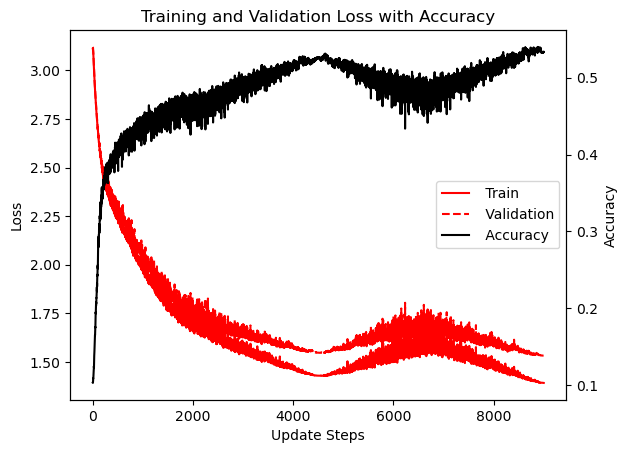

In [67]:
loss_trains = [loss_train]
loss_vals = [loss_val]
accuracies = [accuracy]

fig, ax1, ax2 = plot_loss_curves(loss_trains, loss_vals, accuracies, color=['r', 'k'], casename='sanity check', legend_loc='center right')
plt.savefig(f"./plots/3_layers_NB.png")

In [79]:
hidden_layer_dims = [50, 30, 20, 20, 10, 10, 10, 10]
lamda = 0.005
hyper = {'eta_min':1e-5, 'eta_max':1e-1, 'cycles':2, 'k': 9, 'bs': 100, 'step_size': 2250}
#Train
seed = 0  # Optional, if you want to specify a seed for reproducibility

# Call the MiniBatchGD function
weights, etas, update_step, loss_train, loss_val, accuracy = MiniBatchGD(hidden_layer_dims,X_trn, Y_trn, y_trn, hyper, lamda, X_val, Y_val, y_val, seed)

Number of batches: 450


 50%|█████     | 1/2 [16:59<16:59, 1019.79s/it]

Update at 4500 / 9000, #update:4500: training_loss =1.683819357075212, validation_loss:1.7788624078303958, accuracy: 0.458  


100%|██████████| 2/2 [33:42<00:00, 1011.17s/it]

Update at 9000 / 9000, #update:9000: training_loss =1.598353186274525, validation_loss:1.7223937846410065, accuracy: 0.4856  


In [81]:
P, h = EvaluateClassifier_k(X_tst, weights)
acc = ComputeAccuracy(X_tst, Y_tst, weights)
print(f"Acc = {acc*100}")

Acc = 48.4


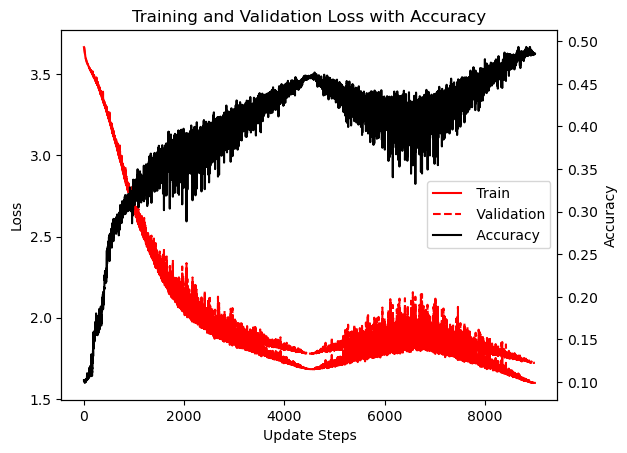

In [80]:
loss_trains = [loss_train]
loss_vals = [loss_val]
accuracies = [accuracy]

fig, ax1, ax2 = plot_loss_curves(loss_trains, loss_vals, accuracies, color=['r', 'k'], casename='sanity check', legend_loc='center right')
plt.savefig(f"./plots/9_layers_NB.png")

In [136]:
import matplotlib.pyplot as plt

def plot_loss_curves(loss_train, loss_val, accuracy, color, casename, legend_loc):
    """
    Plots loss curves for training and validation along with accuracy.

    Args:
    - loss_train (list): List of training losses for each case.
    - loss_val (list): List of validation losses for each case.
    - accuracy (list): List of accuracy values for each case.
    - color (list): List of colors for each case.
    - casename (list): List of names for each case.

    Returns:
    - fig, ax1, ax2: The matplotlib Figure and Axes objects for loss and accuracy.
    """
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    epochs = range(1, len(loss_train[0]) + 1)
    lines1, labels1 = [], []
    lines2, labels2 = [], []

    for i in range(len(loss_train)):
        line1, = ax1.plot(epochs, loss_train[i], f'{color[i]}-', label=f' Train')
        lines1.append(line1)
        line2, = ax1.plot(epochs, loss_val[i], f'{color[i]}--', label=f' Validation')
        lines1.append(line2)
        line3, = ax2.plot(epochs, accuracy[i], f'{color[i+1]}-', label=f' Accuracy')
        lines2.append(line3)

    ax1.set_xlabel('Update Steps')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Loss with Accuracy')

    # Combining legends
    lines = lines1 + lines2
    labels = [line.get_label() for line in lines1] + [line.get_label() for line in lines2]
    ax1.legend(lines, labels, loc=legend_loc)

    return fig, ax1, ax2

BATCH NORMALIZATION 

In [137]:
import numpy as np

def batch_normalize(Z):
    epsilon = 1e-8
    mean = np.mean(Z, axis=1, keepdims=True)
    variance = np.var(Z, axis=1, keepdims=True)
    Z_norm = (Z - mean) / np.sqrt(variance + epsilon)
    return Z_norm, mean, variance
def initialize_weights_k(input_dim, hidden_layer_dims, output_dim, s, seed=None, initialization='he'):
    if seed is not None:
        np.random.seed(seed)

    parameters = {}

    if initialization == 'xavier':
        scale = np.sqrt(2 / (input_dim + hidden_layer_dims[0]))
    elif initialization == 'he':
        scale = s
    else:
        scale = s

    # Initialize weights and biases for the first hidden layer
    parameters['W1'] = np.random.normal(size=(hidden_layer_dims[0], input_dim), loc=0, scale=scale)
    parameters['b1'] = np.zeros((hidden_layer_dims[0], 1))

    # Initialize weights and biases for the hidden layers
    for l in range(1, len(hidden_layer_dims)):
        if initialization == 'xavier':
            scale = np.sqrt(2 / (hidden_layer_dims[l-1] + hidden_layer_dims[l]))
        elif initialization == 'he':
            scale = s
        else:
            scale = s

        parameters['W' + str(l+1)] = np.random.normal(size=(hidden_layer_dims[l], hidden_layer_dims[l-1]), loc=0, scale=scale)
        parameters['b' + str(l+1)] = np.zeros((hidden_layer_dims[l], 1))

    # Initialize weights and biases for the output layer
    scale_out = np.sqrt(2 / hidden_layer_dims[-1])
    parameters['W' + str(len(hidden_layer_dims) + 1)] = np.random.normal(size=(output_dim, hidden_layer_dims[-1]), loc=0, scale=scale_out)
    parameters['b' + str(len(hidden_layer_dims) + 1)] = np.zeros((output_dim, 1))

    return parameters



import numpy as np

"""
def ComputeGradients(X, Y, P, activations, weights, lamda,gamma,beta, use_batch_norm=False):
    n = X.shape[1]
    k = len(weights) // 2
    s = Y.shape[0]  # size of output layer

    G = -(Y - P)

    grads = {}

    # Output layer gradients
    grads['grad_W' + str(k)] = (G @ activations['H' + str(k-1)].T) / n + 2 * lamda * weights['W' + str(k)]
    grads['grad_b' + str(k)] = (G @ np.ones((n, 1)) / n).reshape(s, 1)

    for l in range(k):
        grads['beta' + str(l)] = np.zeros((hidden_layer_dims[l-1], 1))
        grads['gamma' + str(l)] = np.zeros((hidden_layer_dims[l-1], 1))

    # Backpropagation through hidden layers
    for l in range(k-1, 0, -1):
        W_next = weights['W' + str(l+1)]
        G = W_next.T @ G
        m = activations['H' + str(l)].shape[0]
        if use_batch_norm:
            grads['gamma' + str(l)] = np.reshape(1/n * np.multiply(G,activations['S_norm' + str(l)])@np.ones(n), (grads['gamma' + str(l)].shape[0], 1))
            grads['beta' + str(l)]  = np.reshape(1/n * G@np.ones(n),(grads['beta' + str(l)].shape[0], 1))
            G = G * (activations['H' + str(l)] > 0)
            G =np.multiply(G,activations['gamma' + str(l)])
            G = G * batchNorm_backprop(G, activations[f'S{l}'], activations[f'S_mean{l}'], activations[f'S_variance{l}'])
        else:
            G = G * (activations['H' + str(l)] > 0)

        if l == 1:
            m = activations['H1'].shape[0]
            A_prev = X
        else:
            m = activations['H' + str(l)].shape[0]
            A_prev = activations['H' + str(l-1)]

        grads['grad_b' + str(l)] = (G @ np.ones((n, 1)) / n).reshape(m, 1)
        grads['grad_W' + str(l)] = (G @ A_prev.T) / n + 2 * lamda * weights['W' + str(l)]

    return grads

"""
def ComputeGradients(X, Y, P, activations, weights, lamda, gamma, beta, use_batch_norm=False):
    N = X.shape[1]
    k = len(weights) // 2

    grads = {"grad_W": {}, "grad_b": {}, "gamma": {}, "beta": {}}

# Initialize gradients with zeros
    #for key in activations:
    #    grads[key] = [np.zeros_like(activations[key][0]) for _ in range(len(activations[key])+1)]


    # Forward pass
    # ------------------------
    # Backward pass
    # --------------------------
    G_batch = - (Y - P)

    # Update the last layer first as we do not have BN in this layer 
    grads['grad_W' + str(k)] = 1/N * G_batch @ activations['H' + str(k-1)].T + 2 * lamda * weights['W' + str(k)]
    grads['grad_b' + str(k)] = np.reshape(1/N * G_batch @ np.ones((N, 1)), (weights['W' + str(k)].shape[0], 1))

    G_batch = weights['W' + str(k)].T @ G_batch
    activations['H' + str(k-1)][activations['H' + str(k-1)] <= 0] = 0
    G_batch = np.multiply(G_batch, activations['H' + str(k-1)] > 0)

    # for l = k-1, k-2, ..., 1
    if use_batch_norm:
        for l in range(k-1, 0, -1): 
            grads['gamma' + str(l)] = np.reshape(1/N * np.multiply(G_batch, activations['S_norm' + str(l)]) @ np.ones((N, 1)), (activations['gamma' + str(l)].shape[0], 1))
            grads['beta' + str(l)] = np.reshape(1/N * G_batch @ np.ones((N, 1)), (activations['beta' + str(l)].shape[0], 1))

            G_batch = np.multiply(G_batch, activations['gamma' + str(l)])

            G_batch = batchNorm_backprop(G_batch, activations['S' + str(l)], activations['S_mean_mv' + str(l)], activations['S_variance_mv' + str(l)])
            grads['grad_W' + str(l)] = 1/N * G_batch @ activations['H' + str(l-1)].T + 2 * lamda * weights['W' + str(l)]
            grads['grad_b' + str(l)] = np.reshape(1/N * G_batch @ np.ones((N, 1)), (activations['H' + str(l)].shape[0], 1))
            if l > 0:
                G_batch = weights['W' + str(l)].T @ G_batch
                activations['H' + str(l-1)][activations['H' + str(l-1)] <= 0] = 0
                G_batch = np.multiply(G_batch, activations['H' + str(l-1)] > 0)
    else:
        for l in range(k-1, 0, -1):
            grads['grad_W' + str(l)] = 1/N * G_batch @ activations['H' + str(l-1)].T + 2 * lamda * weights['W' + str(l)]
            grads['grad_b' + str(l)] = np.reshape(1/N * G_batch @ np.ones((N, 1)), (activations['H' + str(l)].shape[0], 1))

            G_batch = weights['W' + str(l)].T @ G_batch
            activations['H' + str(l-1)][activations['H' + str(l-1)] <= 0] = 0
            G_batch = np.multiply(G_batch, activations['H' + str(l-1)] > 0)
        

    return grads


def batchNorm_backprop(G_batch, S_batch, mean_batch, var_batch):
    epsilon = 1e-8
    N = G_batch.shape[1]
    sigma1 = np.power(var_batch + epsilon, -0.5)
    sigma2 = np.power(var_batch + epsilon, -1.5)

    G1 = np.multiply(G_batch, sigma1)
    G2 = np.multiply(G_batch, sigma2)

    D = S_batch - mean_batch

    c = np.sum(np.multiply(G2, D), axis=1, keepdims=True)

    G_batch = G1 - 1/N * np.sum(G1, axis=1, keepdims=True) - \
              1/N * np.multiply(D, c)

    return G_batch


def EvaluateClassifier_k(X, b, weights, activations, gamma,beta,use_batch_norm=False):
    num_layers = len(weights) // 2

    activations['A0'] = X  # Input activation
    n = X.shape[1]
    B_eta = b

    for l in range(1, num_layers + 1):
        W = weights['W' + str(l)]
        b = weights['b' + str(l)]
        A_prev = activations['A' + str(l - 1)]
        
        S = W @ A_prev + b
        if l < num_layers:
            if use_batch_norm:
                S_normalized, mean, variance = batch_normalize(S)
                activations['S' + str(l)] = S  # Store unnormalized scores for later use in batch norm
                activations['S_norm' + str(l)] = S_normalized
                activations['S_mean_mv' + str(l)] = (1 - B_eta) * activations['S_mean_mv' + str(l)] + B_eta * mean
                activations['S_variance_mv' + str(l)] = (1 - B_eta) * activations['S_variance_mv' + str(l)] + B_eta * variance
                activations['S_mean' + str(l)] = mean
                activations['S_variance' + str(l)] = variance
                H = customReLu(np.multiply(S_normalized,activations['gamma' + str(l)]) + activations['beta' + str(l)])
                activations['H' + str(l)] = H  # Hidden layer activation
                activations['A' + str(l)] = H 
            else:
                H = customReLu(S)
                activations['H' + str(l)] = H
                activations['A' + str(l)] = H
        else:
            if use_batch_norm:
                S_normalized, mean, variance = batch_normalize(S)
                P = softmax(S)
            else:
                P = softmax(S)
    
    return P, activations

def EvaluateClassifier_test(X, b, weights, activations, gamma,beta,use_batch_norm=False):
    num_layers = len(weights) // 2

    activations['A0'] = X  # Input activation
    beta = b
    n = X.shape[1]

    for l in range(1, num_layers + 1):
        W = weights['W' + str(l)]
        b = weights['b' + str(l)]
        A_prev = activations['A' + str(l - 1)]
        
        S = W @ A_prev + b
        if l < num_layers:
            if use_batch_norm:
                S_normalized, mean, variance = batch_normalize(S)
                activations['S' + str(l)] = S  # Store unnormalized scores for later use in batch norm
                activations['S_norm' + str(l)] = S_normalized
                H = customReLu(np.multiply(S_normalized,activations['gamma' + str(l)]) + activations['beta' + str(l)])
                activations['H' + str(l)] = H  # Hidden layer activation
                activations['A' + str(l)] = H 
            else:
                H = customReLu(S)
                activations['H' + str(l)] = H
                activations['A' + str(l)] = H
        else:
            if use_batch_norm:
                S_normalized, mean, variance = batch_normalize(S)
                P = softmax(S)
            else:
                P = softmax(S)
    
    return P, activations


# Define other necessary functions for batch normalization, gradient computations, etc.


def MiniBatchGD(hidden,s,X, Y, y, hyper, lamda, X_val, Y_val, y_val, seed=seed, use_batch_norm=True):
    # Existing code
    n = X.shape[1]
    eta_min = hyper['eta_min']
    eta_max = hyper['eta_max']
    eta_range = eta_max - eta_min
    step_size = hyper['step_size']
    batch_size = hyper['bs']
    cycles = hyper['cycles']
    B_eta = hyper['b']
    k = hyper['k']

    input_dim = X.shape[0]
    hidden_dim = 50
    output_dim = Y.shape[0]
    # Initialize weights for k layers with or without batch normalization
    weights = initialize_weights_k(input_dim, hidden, output_dim,s, initialization='he',seed=seed)

    # Store exponential moving averages
    moving_means = {f'H{l}': 0 for l in range(1, k + 2)}
    moving_variances = {f'H{l}': 0 for l in range(1, k + 2)}
    loss_train = []
    loss_val = []
    accuracy = []
    etas = []
    update_step = []

    # Store weights at each cycle
    weights_by_cycles = {}

    batches = split_into_batches(X, Y, y, batch_size)

    # Other initialization steps
    batch_counter = 0
    activations = {}
    gamma = {}
    beta = {}
    for l in range(1, k):
        activations['S_mean_mv'+ str(l)] = np.zeros((hidden_layer_dims[l-1], 1))
        activations['S_variance_mv'+ str(l)] = np.zeros((hidden_layer_dims[l-1], 1))
        activations[f'gamma{l}']  = np.ones((hidden_layer_dims[l-1], 1))
        activations[f'beta{l}']   = np.zeros((hidden_layer_dims[l-1], 1))
    
    for cycle in tqdm(range(cycles)):
        for t in tqdm(range(2*cycle * step_size, 2*(cycle + 1) * step_size)):
            # Your existing code goes here

            # eta increasing
            if t >= 2 * cycle * step_size and t < (2 * cycle + 1) * step_size:
                eta = eta_min + (t - 2 * cycle * step_size) / step_size * eta_range
            elif t >= (2 * cycle + 1) * step_size and t < 2 * (cycle + 1) * step_size:
                eta = eta_max - (t - (2 * cycle + 1) * step_size) / step_size * eta_range

            etas.append(eta)
            update_step.append(t + 1)

            X_batch = batches['X'][batch_counter]
            Y_batch = batches['Y'][batch_counter]
            y_batch = batches['y'][batch_counter]
            # Compute activations for all layers with or without batch normalization
            z_scores = {}
            activations['H0'] = X_batch

            # Compute probabilities and activations for output layer

            # Compute gradients for all layers with or without batch normalization
            if use_batch_norm:
                P_batch, activations = EvaluateClassifier_k(X_batch,B_eta, weights, activations,gamma, beta,use_batch_norm=True)
                grads = ComputeGradients(X_batch, Y_batch, P_batch, activations, weights, lamda,gamma, beta, use_batch_norm=True)
            else:
                P_batch, activations = EvaluateClassifier_k(X_batch,B_eta, weights,activations,gamma, beta, use_batch_norm=False)
                grads = ComputeGradients(X_batch, Y_batch, P_batch, activations, weights, lamda,gamma, beta, use_batch_norm=False)

            # Update weights for all layers
            if use_batch_norm:
                for l in range(1, k + 1):
                    weights[f'W{l}'] -= eta * grads[f'grad_W{l}']
                    weights[f'b{l}'] -= eta * grads[f'grad_b{l}']
                for l in range(1,k):
                    activations[f'gamma{l}'] -= eta * grads[f'gamma{l}']
                    activations[f'beta{l}'] -= eta * grads[f'beta{l}']
            else:
                for l in range(1, k + 1):
                    weights[f'W{l}'] -= eta * grads[f'grad_W{l}']
                    weights[f'b{l}'] -= eta * grads[f'grad_b{l}']
            
            batch_counter += 1
            if batch_counter == len(batches['X']):
                batch_counter = 0
            if use_batch_norm:
                loss_train.append(ComputeCost(X, B_eta,Y, weights, lamda,activations,gamma, beta,use_batch_norm=True)[0])
                loss_val.append(ComputeCost(X_val, B_eta,Y_val, weights, lamda,activations,gamma, beta,use_batch_norm=True)[0])
                accuracy.append(ComputeAccuracy(X_val, B_eta,Y_val, weights,activations,gamma, beta,use_batch_norm=True))
            else:
                loss_train.append(ComputeCost(X, B_eta,Y, weights, lamda,activations,gamma, beta,use_batch_norm=False)[0])
                loss_val.append(ComputeCost(X_val, B_eta,Y_val, weights, lamda,activations,gamma, beta,use_batch_norm=False)[0])
                accuracy.append(ComputeAccuracy(X_val, B_eta,Y_val, weights,activations,gamma, beta,use_batch_norm=False))


        print(f"Update at {t + 1} / {2 * cycles * step_size}, #update:{len(update_step)}: training_loss ={loss_train[-1]}, validation_loss:{loss_val[-1]}, accuracy: {accuracy[-1]}  ")

        # Store weights for this cycle
        weights_by_cycles[cycle] = weights.copy()

            # Your existing code goes here

    return weights, etas, update_step, loss_train, loss_val, accuracy


# Define other necessary functions for batch normalization, gradient computations, etc.


In [150]:
lamda = 0.005

hyper = {'eta_min':1e-5, 'eta_max':1e-1, 'cycles':2, 'k': 5, 'bs': 100, 'step_size': 2250, 'b':0.8}

#Train
seed = 0  # Optional, if you want to specify a seed for reproducibility
#hidden_layer_dims = [50, 30, 20, 20, 10, 10, 10, 10]
hidden_layer_dims = [50, 30,20,20]
s = 0.1
weights, etas, update_step, loss_train, loss_val, accuracy = MiniBatchGD(hidden_layer_dims,s,X_trn, Y_trn, y_trn, hyper, lamda, X_val, Y_val, y_val, seed,use_batch_norm=False)

Number of batches: 450


 50%|█████     | 1/2 [15:46<15:46, 946.85s/it]

Update at 4500 / 9000, #update:4500: training_loss =1.9936374565329988, validation_loss:2.0617394372295603, accuracy: 0.4006  


100%|██████████| 2/2 [31:17<00:00, 938.66s/it]

Update at 9000 / 9000, #update:9000: training_loss =1.9240231687984295, validation_loss:2.0218324857526113, accuracy: 0.4248  


In [104]:

acc = ComputeAccuracy(X_tst,hyper['b'], Y_tst, weights)
print(f"Acc = {acc*100}")

TypeError: ComputeAccuracy() missing 3 required positional arguments: 'activations', 'gamma', and 'beta'

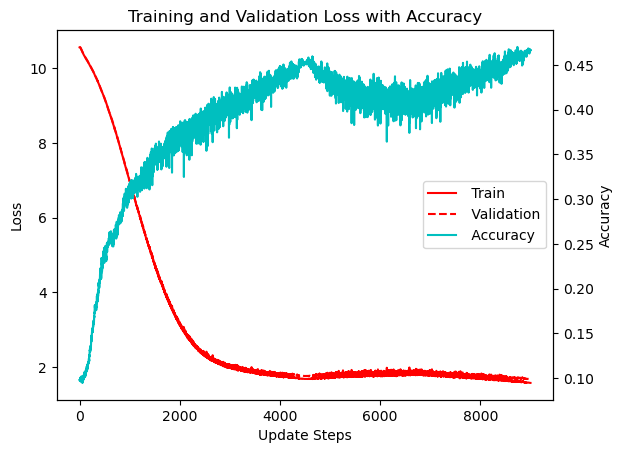

In [146]:
loss_trains = [loss_train]
loss_vals = [loss_val]
accuracies = [accuracy]

fig, ax1, ax2 = plot_loss_curves(loss_trains, loss_vals, accuracies, color=['r', 'c'], casename='sanity check', legend_loc='center right')
plt.savefig(f"./plots/9_layers_NB.png")

In [138]:
lamda = 0.005

hyper = {'eta_min':1e-5, 'eta_max':1e-1, 'cycles':2, 'k': 9, 'bs': 100, 'step_size': 2250, 'b':0.8}

#Train
seed = 0  
s = 0.1
hidden_layer_dims = [50, 30, 20, 20, 10, 10, 10, 10]
weights, etas, update_step, loss_train, loss_val, accuracy = MiniBatchGD(hidden_layer_dims,s,X_trn, Y_trn, y_trn, hyper, lamda, X_val, Y_val, y_val, seed,use_batch_norm=True)

Number of batches: 450


 50%|█████     | 1/2 [15:57<15:57, 957.98s/it]

Update at 4500 / 9000, #update:4500: training_loss =2.3901250615363767, validation_loss:2.390319351106303, accuracy: 0.095  


100%|██████████| 2/2 [31:15<00:00, 937.76s/it]

Update at 9000 / 9000, #update:9000: training_loss =2.3035459648346506, validation_loss:2.3037402544046097, accuracy: 0.095  


In [108]:
acc = ComputeAccuracy(X_tst,hyper['b'], Y_tst, weights)
print(f"Acc = {acc*100}")       

Acc = 48.03


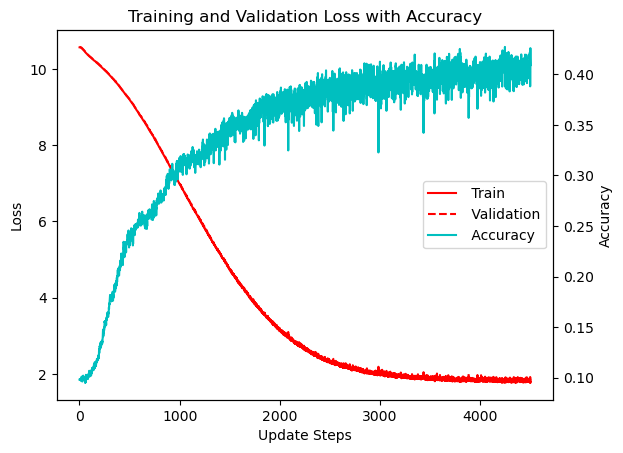

In [115]:
loss_trains = [loss_train]
loss_vals = [loss_val]
accuracies = [accuracy]

fig, ax1, ax2 = plot_loss_curves(loss_trains, loss_vals, accuracies, color=['r', 'c'], casename='sanity check', legend_loc='center right')
plt.savefig(f"./plots/9_layers_NB.png")

EXERCISE 4: 3-LAYER AND 3 INITIALIZATIONS

In [101]:
lamda = 0.003

hyper = {'eta_min':1e-5, 'eta_max':1e-1, 'cycles':2, 'k': 3, 'bs': 100, 'step_size': 2250, 'b':0.8}

#Train
seed = 0  # Optional, if you want to specify a seed for reproducibility
hidden_layer_dims = [50, 50]
s = 0.1
weights, etas, update_step, loss_train, loss_val, accuracy = MiniBatchGD(hidden_layer_dims,s,X_trn, Y_trn, y_trn, hyper, lamda, X_val, Y_val, y_val, seed,use_batch_norm=True)

Number of batches: 450


 50%|█████     | 1/2 [09:59<09:59, 599.89s/it]

Update at 2250 / 9000, #update:2250: training_loss =1.599039915565251, validation_loss:1.658724301004613, accuracy: 0.451  


100%|██████████| 2/2 [20:20<00:00, 610.04s/it]

Update at 4500 / 9000, #update:4500: training_loss =1.6339202257724847, validation_loss:1.7101381036178696, accuracy: 0.4476  


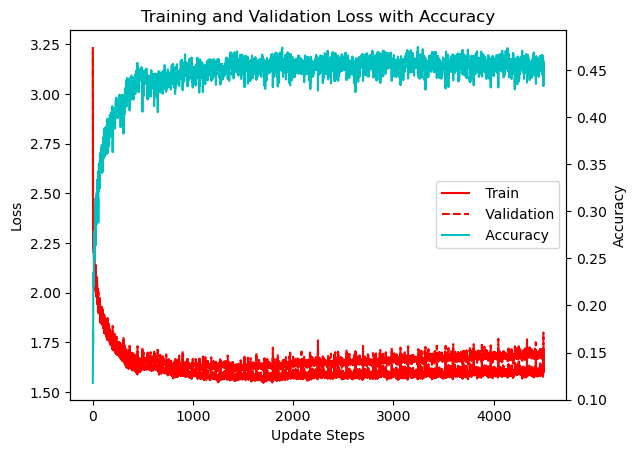

In [102]:
#acc = ComputeAccuracy_test(X_tst,hyper['b'], Y_tst, weights,activations)
#print(f"Acc = {acc*100}")
loss_trains = [loss_train]
loss_vals = [loss_val]
accuracies = [accuracy]

fig, ax1, ax2 = plot_loss_curves(loss_trains, loss_vals, accuracies, color=['r', 'c'], casename='sanity check', legend_loc='center right')
plt.savefig(f"./plots/3_layers_BN_0003_00001.png")